In [1]:
from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike


import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import random as jrandom
import equinox as eqx

import optax


from functools import partial

from collections.abc import Generator
from typing_extensions import TypeAlias



from dataclasses import dataclass, asdict, astuple

In [2]:
print(jax.devices())


[CudaDevice(id=0)]


# Utils

In [3]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0

#class ModelState(eqx.Module):
#    S0: float
#    v0: float

class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [4]:
import matplotlib.pyplot as plt

#def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
#    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
#    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')
#
#    print(init_spots.shape)
#    print(states.S0.shape)
#    # plt.plot(init_spots, states
#    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
#    plt.legend()
#    plt.xlabel('initial spot price')
#    plt.ylabel('payoff')
#    # plt.ylim(-1, 1000)
#    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("$v_0$")
    ax.set_zlabel(label)
    return fig


In [5]:
def mse(y_pred, y_true):
    return jnp.mean((y_pred - y_true)**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))


In [6]:
def normalize(x, x_mean, x_std):
    return (x - x_mean) / x_std

# HVP stuff

In [7]:

# HVP for single point and single direction from Bachelier
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]

# from bachelier
def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))




In [8]:
#import jax
#import jax.numpy as jnp
#
#def hvp(f, x, v):
#    """
#    Computes the Hessian-vector product H_f(x) @ v in a way that is
#    fully differentiable through f's parameters.
#    
#    f: R^n -> R, a pure JAX-traceable scalar function of x.
#    x: array of shape (n,) — point at which to probe
#    v: array of shape (n,) — direction vector
#    returns: H_f(x) @ v, array of shape (n,)
#    """
#    # grad_f(x) = ∇_x f(x), differentiable in f's parameters
#    grad_f = jax.grad(f)
#    # jvp returns (gradient, H@v); we take the second component
#    return jax.jvp(grad_f, (x,), (v,))[1]
#
#def hvp_batch(f, inputs, directions):
#    """
#    Vectorized Hessian-vector products:
#      outputs[i,j] = H_f(inputs[i]) @ directions[j]
#    
#    f: R^n -> R, pure JAX-traceable
#    inputs: array (batch, n)
#    directions: array (k, n)
#    
#    returns: array shape (batch, k, n)
#    """
#    # vectorize hvp over inputs (axis 0) and directions (axis 0)
#    hvp_fn = jax.vmap(jax.vmap(lambda x, v: hvp(f, x, v),
#                               in_axes=(None, 0)),  # map over directions
#                      in_axes=(0, None))          # then map over inputs
#    return hvp_fn(inputs, directions)


# Heston

In [9]:
from typing import Final
#class ModelState(eqx.Module):
#    S0: float
#    v0: float

## just for testing
#class DDModelState(eqx.Module):
#    S0: ModelState
#    v0: ModelState

    
class Heston(eqx.Module):

    
    # for basket
    basket_dim: Final[int]
    basket_weights: Float[Array, "basket_dim"]


    spot_range:Range = Range(50.0, 150.0)
    vol_range: Range = Range(0.01, 0.1)

    mc_time_steps: int = 1024 # number of time steps for the Monte Carlo simulation
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    # for semi-closed-form solution
    num_w: int = 512
    w_max: float = 100.0

    
    


    def closed_form_price(self, S0, v0):
        """
        Compute the Heston model European call price using the semi-closed-form solution using numerical integration in JAX.

        Math from:  https://www.ma.imperial.ac.uk/~ajacquie/IC_Num_Methods/IC_Num_Methods_Docs/Literature/Heston.pdf
        and form:   https://xilinx.github.io/Vitis_Libraries/quantitative_finance/2019.2/methods/cf-ht.html#chrso2014
        
        Parameters:
        - S0: initial spot price
        - v0: initial variance
       
        Returns:
        - call option price under Heston model
        """

        sigma = self.xi # volatility of volatility

        # integration grid
        w = jnp.linspace(0.0, self.w_max, self.num_w)[1:]  # avoid w=0

        # Heston characteristic function components
        a = self.kappa * self.theta
        def C_D(wi):
            alpha = -0.5 * wi**2 - 0.5j * wi
            beta  = alpha - 1j * self.rho * sigma * wi
            gamma = 0.5 * sigma**2

            h = jnp.sqrt(beta**2 - 4 * alpha * gamma)
            rp = (beta + h) / (sigma**2)
            rm = (beta - h) / (sigma**2)
            g = rm / rp

            exp_neg_ht = jnp.exp(-h * self.T)
            C = a * (rm * self.T - (2.0 / sigma**2) * jnp.log((1 - g * exp_neg_ht) / (1 - g)))
            D = rm * (1 - exp_neg_ht) / (1 - g * exp_neg_ht)
            return C, D

        # vectorize C and D over w
        C_vec, D_vec = jax.vmap(C_D)(w)

        # characteristic function Psi
        log_term = jnp.log(S0) + self.r * self.T
        def Psi(wi, Ci, Di):
            return jnp.exp(Ci * self.theta + Di * v0 + 1j * wi * log_term)

        Psi_w      = Psi(w,      C_vec, D_vec)
        Psi_w_minus_i = Psi(w - 1j, *jax.vmap(C_D)(w - 1j))
        Psi_minus_i = Psi(-1j, *C_D(-1j))

        # integrands for Pi1 and Pi2
        integrand1 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w_minus_i / (1j * w * Psi_minus_i))
        integrand2 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w      / (1j * w))

        # numerical integration via the trapezoidal rule
        Pi1 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand1, w)
        Pi2 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand2, w)

        # final price
        price = S0 * Pi1 - jnp.exp(-self.r * self.T) * self.K * Pi2
        return price
    

    def closed_form_basket_price(self, basket_S0s, basket_v0s):
        # vectorize single‐asset pricer over the basket axis
        prices = jax.vmap(self.closed_form_price)(basket_S0s, basket_v0s)
        return jnp.dot(self.basket_weights, prices)
    

    def closed_form_basket_price_x(self, x_flat):
        d = self.basket_dim
        S0s = x_flat[:d]        # first n_dims entries
        v0s = x_flat[d:]        # next n_dims entries
        return self.closed_form_basket_price(S0s, v0s)




    
    #def hessian_2x2_for_basket(self, S0s, v0s):
    #    
    #    
    #    hvps = hvp_batch(
    #        f=self.closed_form_basket_price_x,
    #        # NOTE this is where later the extra basket dim can be added
    #        inputs=jnp.array([(initial_spots, initial_vols)]), 
    #        directions=jnp.array([[1.0, 0.0], [0.0, 1.0]]) 
    #    )
    #    
    #    H_block = jnp.transpose(hvps[0], (1,0))
    #
    #    return H_block




    def sample_data_closed_form(self, key, n_samples=256, is_test=False):    
        
        key, subkey = jrandom.split(key)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        
        initial_states = jrandom.uniform(
            subkey, 
            shape=(n_samples, self.basket_dim, 2), 
            minval=minvals, 
            maxval=maxvals
        ) # (batch, n_dims, 2)
        S0s = initial_states[..., 0]    # (batch, n_dims)
        v0s = initial_states[..., 1]     # (batch, n_dims)
    



        value_and_grad_fn = jax.value_and_grad(self.closed_form_basket_price, argnums=(0,1))
        y, (dS0s, dV0s) = jax.vmap(value_and_grad_fn)(S0s, v0s)
        dydx = jnp.stack([dS0s, dV0s], axis=-1)
        # x:     (batch, n_dims, 2)
        # y:     (batch,)
        # dydx:  (batch, n_dims, 2)
        #print("x shape: ", initial_states.shape)
        #print("y shape: ", y.shape)
        #print("dydx shape: ", dydx.shape)

        
        


        ## Normalize the data
        # TODO make this work
        x_mean = jnp.mean(initial_states, axis=0)   # (basket, 2)
        x_std = jnp.std(initial_states, axis=0)     # (basket, 2)
        y_mean = jnp.mean(y)                        # scalar
        y_std = jnp.std(y)                          # scalar        
        x_normalized = normalize(initial_states, x_mean, x_std)
        y_normalized = normalize(y, y_mean, y_std)
        dydx_normalized = dydx * (x_std / y_std)[None, ...]

        norm_values = {
            "x_mean": x_mean,
            "x_std": x_std,
            "y_mean": y_mean,
            "y_std": y_std,
        }

    
        ## flatten before returning    
        x_flat = initial_states.reshape(initial_states.shape[0], -1)
        dydx_flat = dydx.reshape(dydx.shape[0], -1)
        x_normalized_flat = x_normalized.reshape(x_normalized.shape[0], -1)
        x_raw_flat = initial_states.reshape(initial_states.shape[0], -1)
        dydx_normalized_flat = dydx_normalized.reshape(dydx_normalized.shape[0], -1)

        if not is_test:
            #return x_flat, y, dydx_flat, None
            return x_normalized_flat, y_normalized, dydx_normalized_flat, norm_values



        if is_test:
            # use jax.hessian to compute the second derivatives
            
            x_flat = initial_states.reshape(n_samples, 2*self.basket_dim)

            H_full = jax.vmap(jax.hessian(self.closed_form_basket_price_x))(x_flat)

            H_blocks = H_full.reshape(
                n_samples,
                self.basket_dim, 2,
                self.basket_dim, 2
            ) # (batch, basket, 2 basket, 2)

            # TODO when calculating 2nd order loss with basket size >1 we
            # do actually need the full Hessian returned. Then diag only for visualization?
            #print("H_blocks shape", H_blocks.shape)


            ## only care about diagonal asset‐blocks (i=j)
            #H_diag = jnp.stack([H_blocks[:, i, :, i, :] for i in range(self.basket_dim)], axis=1)  # -> (batch, basket_dim, 2, 2)
            #ddyddx = H_diag
            ##print("ddyddx shape: ", ddyddx.shape)
            ## normalizing the data
            #scale = (x_std[:, :, None] * x_std[:, None, :]) / y_std  
            ## (basket_dim, 2, 2)
            ## add a batch‐axis
            #scale = scale[None, ...]  
            ##(1, basket_dim, 2, 2)
            #ddyddx_normalized =  ddyddx * scale
            
            scale_full = (x_std[:, :, None, None] * x_std[None, None, :, :]) / y_std
            # scale_full: (n, 2, n, 2)

            # 4) broadcast and apply
            H_blocks_norm = H_blocks * scale_full[None, ...]
            # H_blocks_norm: (batch, n, 2, n, 2)
            #norm_values["H_scale_full"] = scale_full
            ddyddx_normalized = H_blocks_norm


            
            #return x_flat, y, dydx_flat, ddyddx, None
            return x_normalized_flat, y_normalized, dydx_normalized_flat, ddyddx_normalized, norm_values

       
        #else:
        #    initial_states_flat = initial_states.reshape(n_samples, 2*self.basket_dim)  # (batch, 2*basket_dim)
        #
        #    k = 3
        #    key, subkey = jrandom.split(key)
        #    rand_directions = jrandom.normal(subkey, shape=(k, self.basket_dim, 2))
        #    directions = rand_directions
        #    #directions = pre_built_directions
        #    directions_flat = directions.reshape(k, 2*self.basket_dim)  # (k, 2*basket_dim)
        #
        #    hvps_flat = hvp_batch(
        #        f=self.closed_form_basket_price_x,
        #        inputs=initial_states_flat, 
        #        directions=directions_flat 
        #    )# (batch_size, k, 2*basket_dim) 
        #
        #    hvps = hvps_flat.reshape(n_samples, k, self.basket_dim, 2) 
        #    # (batch_size, k, basket_dim, 2)
        #
        #    ddyddx = hvps
        #    #print("ddyddx shape: ", ddyddx.shape)


        # NOTE
        # with basket now the shapes are:
        # x: (batch_size, basket_dim, 2)
        # y: (batch_size, )
        # dydx: (batch_size, basket_dim, 2)
        # ddyddx: (batch_size, k_probe_directions, basket_dim, 2, 2)


        




        #x = initial_states
        #x_flat = x.reshape(x.shape[0], -1)
        #dydx_flat = dydx.reshape(dydx.shape[0], -1)
        #return x_flat, y, dydx_flat, ddyddx


    

test closed form

In [13]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

basket_dim = 1

ref_model = Heston(
    basket_dim=basket_dim,
    basket_weights=jrandom.uniform(subkey, shape=(basket_dim,), minval=1.0, maxval=10.0),
    #basket_weights = jnp.ones(shape=(basket_dim)), # for testing
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

test closed form

In [14]:
test_set = ref_model.sample_data_closed_form(key, n_samples=1024, is_test=True)
print("test_set shapes:", test_set[0].shape, test_set[1].shape, test_set[2].shape, test_set[3].shape)

test_set shapes: (1024, 2) (1024,) (1024, 2) (1024, 1, 2, 1, 2)


shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)
ddyddx shape:  (1024, 2, 2)


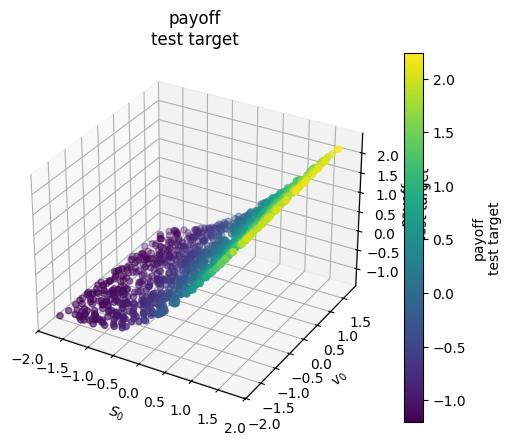

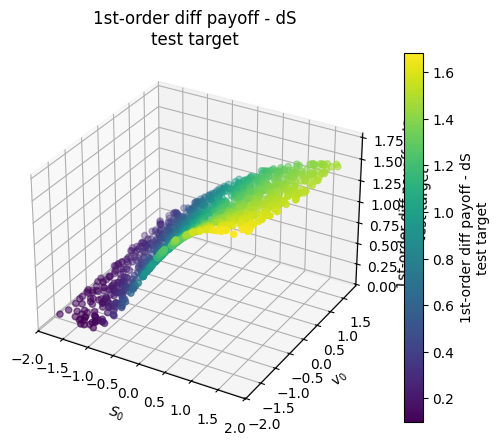

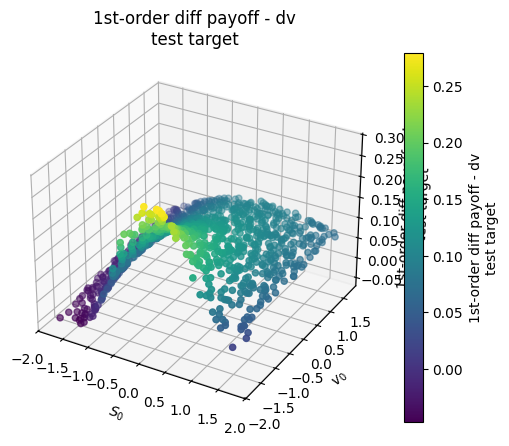

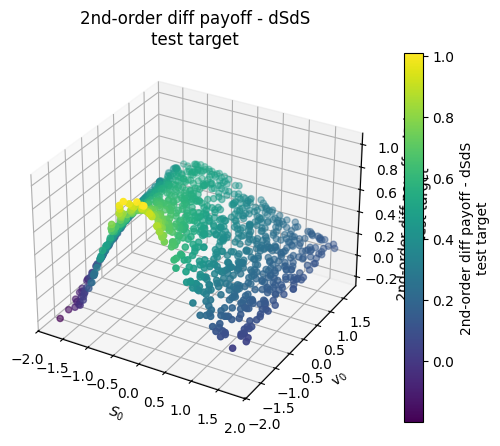

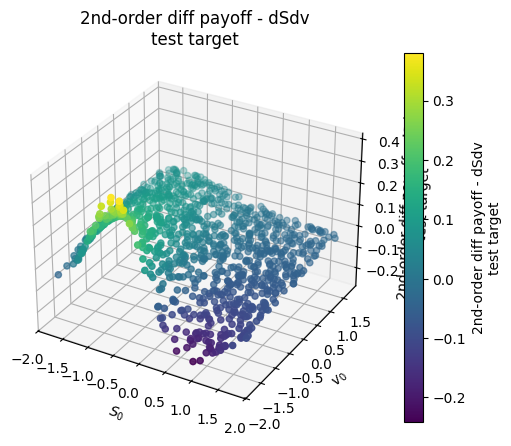

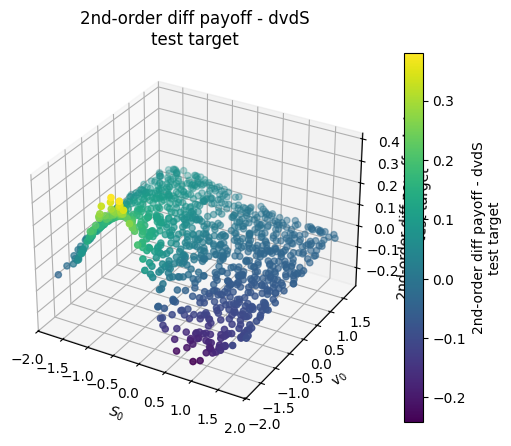

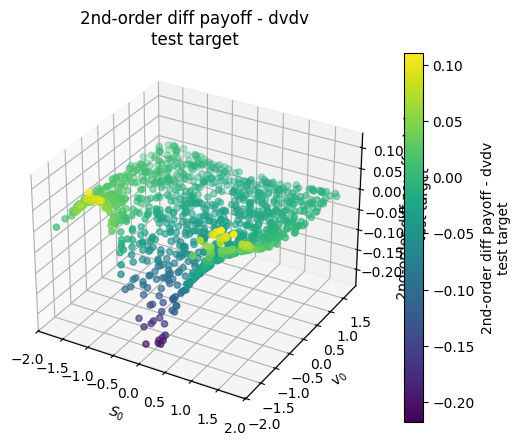

In [15]:
# visulaize the test set
x, y, dydx, ddyddx, _ = test_set

x = x.reshape(x.shape[0], basket_dim, 2)
dydx = dydx.reshape(dydx.shape[0], basket_dim, 2)


# for visualization slice out diagonal blocks of Hessian
ddyddx = jnp.stack([ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)

# selecting first basket dimension
basket_i = 0

x = x[:, basket_i, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, basket_i, :]  # (batch_size, 2)
ddyddx = ddyddx[:, basket_i, :, :]  # (batch_size, k_probe_directions, 2, 2)

## average over the basket dimension
#x = x.mean(axis=1)
#y = y
#dydx = dydx.mean(axis=1) 
#ddyddx = ddyddx.mean(axis=2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




xs = x[..., 0]
ys = x[..., 1]


fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest target")

fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv\ntest target")
#
#
#
#
#num_probes = ddyddx.shape[1]
#for j in range(num_probes):
#    # second‐order effect in the S0‐direction
#    fig_ddS = plot_3d_differential_data(xs, ys, ddyddx[:, j, 0], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dS² direction)\ntrain target")
#    # second‐order effect in the v0‐direction
#    fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, j, 1], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dv² direction)\ntrain target")



fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], "2nd-order diff payoff - dSdS\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], "2nd-order diff payoff - dSdv\ntest target")
fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], "2nd-order diff payoff - dvdS\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], "2nd-order diff payoff - dvdv\ntest target")



In [16]:

closed_form_vis_batch = ref_model.sample_data_closed_form(key, n_samples=1024)
print("sample batch shapes:", closed_form_vis_batch[0].shape, closed_form_vis_batch[1].shape, closed_form_vis_batch[2].shape)

sample batch shapes: (1024, 2) (1024,) (1024, 2)


In [ ]:
# with basket the shapes are:
# x: (batch_size, basket_dim, 2)
# y: (batch_size, )
# dydx: (batch_size, basket_dim, 2)

shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)


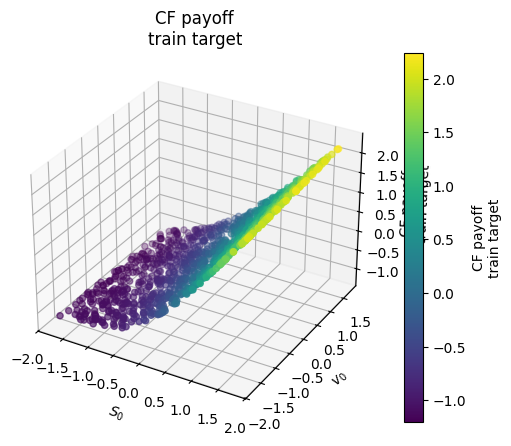

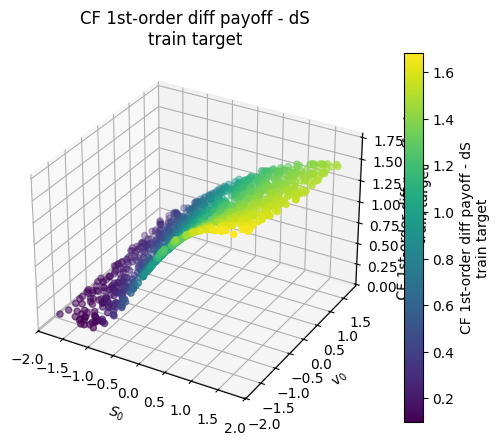

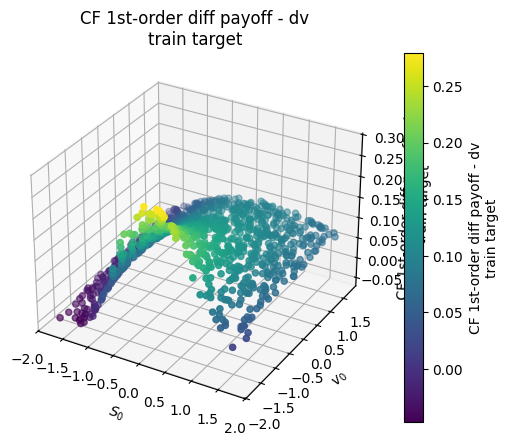

In [17]:

x, y, dydx, _ = closed_form_vis_batch

x = x.reshape(x.shape[0], basket_dim, 2)
dydx = dydx.reshape(dydx.shape[0], basket_dim, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
#ddyddx = ddyddx[:, :, 0, :]  # (batch_size, k_probe_directions, 2, 2)

## average over the basket dimension
#x = x.mean(axis=1)
#y = y
#dydx = dydx.mean(axis=1) 
#ddyddx = ddyddx.mean(axis=2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
#print("ddyddx shape: ", ddyddx.shape)




xs = x[..., 0]
ys = x[..., 1]


fig_payoff = plot_3d_differential_data(xs, ys, y, "CF payoff\ntrain target")

fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "CF 1st-order diff payoff - dS\ntrain target")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "CF 1st-order diff payoff - dv\ntrain target")



#
#num_probes = ddyddx.shape[1]
#for j in range(num_probes):
#    # second‐order effect in the S0‐direction
#    fig_ddS = plot_3d_differential_data(xs, ys, ddyddx[:, j, 0], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dS² direction)\ntrain target")
#    # second‐order effect in the v0‐direction
#    fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, j, 1], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dv² direction)\ntrain target")



# Learning

### Model

In [18]:
import equinox as eqx
import jax.numpy as jnp
from typing import Sequence

class BasketSurrogate(eqx.Module):
    asset_mlps: Sequence[eqx.nn.MLP]   # one MLP per asset
    basket_weights: jnp.ndarray               # shape (basket_dim,)

    def __call__(self, x_flat: jnp.ndarray) -> jnp.ndarray:
        # x_flat: (2*basket_dim,)
        basket_dim = len(self.asset_mlps)
        x = x_flat.reshape(basket_dim, 2)   # → (basket_dim, 2)
        # per-asset prices
        prices = [mlp(x[i]) for i, mlp in enumerate(self.asset_mlps)]
        # weighted sum
        return jnp.dot(self.basket_weights, jnp.stack(prices))[0]
    


In [19]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

### Loss Functions

In [63]:
@eqx.filter_jit
def value_loss(model, batch):
    x = batch[0]
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)


@eqx.filter_jit
def grad_loss(model, batch):
        
    x = batch[0]
    dydx = batch[2]

    _, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

    
    grad_loss = mse(dydx_pred, dydx)
    
    return grad_loss


@eqx.filter_jit
def hess_loss(model, batch, key):

    x = batch[0]
    norm_values = batch[3]

    # TODO 2nd order loss in random directions
    k = 10
    key, subkey = jrandom.split(key)
    rand_directions = jrandom.normal(subkey, shape=(k, basket_dim, 2))
    directions = rand_directions
    
    
      
    # 2nd order targets via pricing function
    # undo normalization of x for pricing function
    x_mean = norm_values["x_mean"]
    x_std = norm_values["x_std"]
    y_mean = norm_values["y_mean"]
    y_std = norm_values["y_std"]
    x_norm = x.reshape(x.shape[0], basket_dim, 2)                      # (batch, n, 2)                                 # (n, 2)
    x_raw  = x_norm * x_std[None, :, :] + x_mean[None, :, :]      # (batch, n, 2)
    x_raw_flat = x_raw.reshape(x.shape[0], 2*basket_dim)               # (batch, 2*n)
    dirs_scaled = directions * x_std[None, :, :]
    dirs_scaled_flat  = dirs_scaled.reshape(k, 2*basket_dim) 
    
    # get the actual targets
    target_hvps = hvp_batch(
        f=ref_model.closed_form_basket_price_x,
        inputs=x_raw_flat, 
        directions=dirs_scaled_flat
    )

    # re-normalize target_hvps for comparison with model preds
    # TODO thius is ugly af
    hvp = target_hvps.reshape(x.shape[0], k, basket_dim, 2)          # (batch, k, n, 2)
    diag_scale = (x_std**1) / y_std                              # (n, 2)
    hvp_norm = hvp * diag_scale[None, None, :, :]                # (batch, k, n, 2)
    target_hvps = hvp_norm.reshape(x.shape[0], k, 2*basket_dim)


    # 2nd order preds via model
    pred_hvps = hvp_batch(
        f=MakeScalar(model),
        inputs=x, 
        directions=directions.reshape(k, 2*basket_dim)
    )
    
    hess_loss = mse(pred_hvps, target_hvps) 
    
    return hess_loss

In [46]:
def standard_loss_fn(model, batch):
    x = batch[0]
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)


@eqx.filter_jit
def second_order_loss_fn(model: eqx.nn.MLP, batch, key, ref_model) -> Float:
    
    #batch = ref_model.sample_data(key, batch_size)
        
    x = batch[0]
    y = batch[1]
    dydx = batch[2]
    norm_values = batch[3]
    

    #print("x shape: ", x.shape)
    #print("y shape: ", y.shape)
    #print("dydx shape: ", dydx.shape)
    #print("ddyddx shape: ", ddyddx.shape)
    #print("")
    #return .0


    # TODO normalization ?
    #x = (x - x_mean) / x_std
    #y = (y - y_mean) / y_std
    
    # TODO loss balancing
    #lam = 1
    #n_dims = model.in_size
    #lambda_scale = lam * n_dims
    #alpha = 1.0/(1.0 + lambda_scale)
    #beta = lambda_scale/(1.0 + lambda_scale)
    #gamma = 0.0

   

    
    
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    
    #print("y_pred shape: ", y_pred.shape)
    #print("dydx_pred shape: ", dydx_pred.shape)
    #print("")
    #return .0
    
    # TODO 2nd order loss in random directions
    k = 10
    key, subkey = jrandom.split(key)
    rand_directions = jrandom.normal(subkey, shape=(k, basket_dim, 2))
    directions = rand_directions
    
    



    # 2nd order targets via pricing function
    

    # undo normalization of x for pricing function
    x_mean = norm_values["x_mean"]
    x_std = norm_values["x_std"]
    y_mean = norm_values["y_mean"]
    y_std = norm_values["y_std"]
    x_norm = x.reshape(x.shape[0], basket_dim, 2)                      # (batch, n, 2)                                 # (n, 2)
    x_raw  = x_norm * x_std[None, :, :] + x_mean[None, :, :]      # (batch, n, 2)
    x_raw_flat = x_raw.reshape(x.shape[0], 2*basket_dim)               # (batch, 2*n)
    dirs_scaled = directions * x_std[None, :, :]
    dirs_scaled_flat  = dirs_scaled.reshape(k, 2*basket_dim) 
    
    # get the actual targets
    target_hvps = hvp_batch(
        f=ref_model.closed_form_basket_price_x,
        inputs=x_raw_flat, 
        directions=dirs_scaled_flat
    )

    # re-normalize target_hvps for comparison with model preds
    # TODO thius is ugly af
    hvp = target_hvps.reshape(x.shape[0], k, basket_dim, 2)          # (batch, k, n, 2)
    diag_scale = (x_std**1) / y_std                              # (n, 2)
    hvp_norm = hvp * diag_scale[None, None, :, :]                # (batch, k, n, 2)
    target_hvps = hvp_norm.reshape(x.shape[0], k, 2*basket_dim)





    # (batch_size, k, 2*basket_dim) 
    #print("target_hvps shape:", target_hvps.shape)
    #return .0

    #hvps = hvps_flat.reshape(n_samples, k, self.basket_dim, 2) 
    # (batch_size, k, basket_dim, 2)
    
    # 2nd order preds via model
    pred_hvps = hvp_batch(
        f=MakeScalar(model),
        inputs=x, 
        directions=directions.reshape(k, 2*basket_dim)
    )
    # (batch_size, k, basket_dim*2)
    #print("pred_hvps shape:", pred_hvps.shape)

    #print("target nans:", jnp.isnan(target_hvps).sum())
    #print("pred nans:", jnp.isnan(target_hvps).sum())


    ## Ture Hessians vis jax.hessian for testing
    #model_ddyddx = vmap(jax.hessian(MakeScalar(model)))(x)
    #model_ddyddx = model_ddyddx.reshape(x.shape[0], basket_dim, 2, basket_dim, 2)
    #model_ddyddx_diag = jnp.stack([model_ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)
    #true_ddyddx = vmap(jax.hessian(ref_model.closed_form_basket_price_x))(x_raw_flat)
    #true_ddyddx_blocks = true_ddyddx.reshape(
    #            x.shape[0],
    #            basket_dim, 2,
    #            basket_dim, 2
    #        )
    #scale_full = (x_std[:, :, None, None] * x_std[None, None, :, :]) / y_std
    #true_ddyddx = true_ddyddx_blocks * scale_full[None, ...]
    #true_ddyddx_diag = jnp.stack([true_ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)
    #print("target nans:", jnp.isnan(true_ddyddx).sum())
    #print("pred nans:", jnp.isnan(model_ddyddx).sum())




    #ddyddx_pred = vmap(jax.hessian(MakeScalar(model)))(x)
    assert(target_hvps.shape == pred_hvps.shape)
    
    #print("ddyddx_pred shape: ", ddyddx_pred.shape)
    #print("")
    #return .0



    value_loss = mse(y_pred, y)
    grad_loss = mse(dydx_pred, dydx)
    hess_loss = mse(pred_hvps, target_hvps) 
    #hess_loss = mse(model_ddyddx, true_ddyddx)
    #hess_loss = mse(model_ddyddx_diag, true_ddyddx_diag) 

    
    #hess_loss = mse(ddyddx_pred, ddyddx)
    #hess_loss = 0


    #jax.debug.print("value loss: {}", value_loss)
    #jax.debug.print("grad loss: {}", grad_loss)
    #jax.debug.print("hess loss: {}", hess_loss)
    #jax.debug.print("---------------------------------")
    


    #gamma = epoch_percent/20
    #alpha = (1-gamma)/2
    #beta = (1-gamma)/2

    alpha = 1/3
    beta = 1/3
    gamma = 1/3
    #alpha = 0.4
    #beta = 0.4
    #gamma = 0.2
    #alpha = 0.49
    #beta = 0.49
    #gamma = 1 - (alpha + beta)
    
    loss = alpha*value_loss + beta*grad_loss + gamma*hess_loss
    #loss = 0.5*value_loss + 0.5*grad_loss

    return loss




### Train

In [64]:
from jax import tree_util

def tree_dot(a, b):
    """Dot product between two PyTrees of the same structure."""
    a_flat, _ = tree_util.tree_flatten(a)
    b_flat, _ = tree_util.tree_flatten(b)
    return sum([jnp.vdot(x, y) for x, y in zip(a_flat, b_flat)])

def tree_scale(a, s):
    """Scale every leaf of PyTree a by scalar s."""
    return jax.tree_map(lambda x: s * x, a)

def pc_project(g, onto):
    """
    Project g so that it has no negative component along 'onto'.
    If ⟨g,onto⟩ < 0, remove that component; otherwise leave g unchanged.
    """
    dot = tree_dot(g, onto)
    norm2 = tree_dot(onto, onto)
    # only project if they conflict
    coeff = jnp.where(dot < 0, dot / (norm2 + 1e-12), 0.0)
    return jax.tree_map(lambda gi, oi: gi - coeff * oi, g, onto)

In [73]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]


def train(
    model: PyTree,
    test_data: Tuple,
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int,
    batch_size: int,
    key: PRNGKeyArray,
    ref_model,
) -> PyTree:
    

    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch_size: int, batch_key):
        
        batch = ref_model.sample_data_closed_form(batch_key, batch_size)

        #loss_value, grads = eqx.filter_value_and_grad(standard_loss_fn)(model, batch)
        loss_value, grads = eqx.filter_value_and_grad(second_order_loss_fn)(model, batch, batch_key, ref_model)
        
        #l_value, g_value = eqx.filter_value_and_grad(value_loss)(model, batch)
        #l_grad, g_grad = eqx.filter_value_and_grad(grad_loss)(model, batch)
        #l_hess, g_hess = eqx.filter_value_and_grad(hess_loss)(model, batch, batch_key)
        ## PC‐project the Hessian gradient so it never conflicts
        #g_hess = pc_project(g_hess, g_value)
        #g_hess = pc_project(g_hess, g_grad)
        ## choose your weights
        #alpha, beta, gamma = 0.45, 0.45, 0.1
        ## form the combined gradient
        #grads = jax.tree_map(
        #    lambda gv, gg, gh: alpha*gv + beta*gg + gamma*gh,
        #    g_value, g_grad, g_hess
        #)
        #loss_value = alpha*l_value + beta*l_grad + gamma*l_hess
        



        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps = n_epochs * n_batches_per_epoch
    print(f"Training for {n_epochs} epochs with {n_batches_per_epoch} batches per epoch and batch size {batch_size}.")
    
    keys = jrandom.split(key, n_steps)

    #epoch_percent = 0
    for i, batch_key in enumerate(keys):
        
        # print(i)
        # print(batch["normalized_initial_states"])
        # print(batch["normalized_payoffs"].shape)
        with jax.profiler.StepTraceAnnotation("Train Step", step_num=i):  

            model, opt_state, train_loss = train_step(model, opt_state, batch_size, batch_key)
        
        if i % n_batches_per_epoch == 0:
            epoch_stats = f"Finished epoch {int(i/n_batches_per_epoch)+1} | Train Loss: {train_loss:.5f}"    

            
            # test data evaluation
            if test_data:
                x_test_flat = test_data[0]#test_data[0].reshape(test_data[0].shape[0], -1)  # flatten the input
                
                
                test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(model))(x_test_flat)
                #test_pred_ddys = vmap(jax.hessian(MakeScalar(model)))(test_set[0])
                y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
                #dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
                #ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))
                test_loss = y_error # (y_error + dy_error + ddy_error) / 3.0
                epoch_stats += f" | Test Loss: {test_loss:.5f}"
            
            print(epoch_stats)
        
        #if i % (n_batches_per_epoch*20) == 0:
        #    epoch_percent = i / n_steps

            
    return model

In [74]:
n_epochs = 100
n_batches_per_epoch = 32
BATCH_SIZE = 256


basket_dim = 2
basket_weights = jrandom.uniform(subkey, shape=(basket_dim,), minval=1.0, maxval=10.0)

# NOTE batch:_size * n_batches_per_epoch = 8192

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

ref_model = Heston(
    basket_dim=basket_dim,
    basket_weights=basket_weights,
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

test_set = ref_model.sample_data_closed_form(key, n_samples=1024, is_test=True)

# in_size is 2 for initial_spot and initial_vol
input_dims = 2*basket_dim


key, subkey = jax.random.split(key)
mlp = eqx.nn.MLP(key=subkey, in_size=input_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp


def make_asset_mlp(key):
    mlp = eqx.nn.MLP(
        key=key,
        in_size=2,      # (S0,v0)
        out_size=1,     # price
        width_size=20,
        depth=3,
        activation=jax.nn.elu
    )
    return init_linear_weight(mlp, trunc_init, key)

keys = jax.random.split(key, basket_dim)
asset_mlps = [make_asset_mlp(mlp_key) for mlp_key in keys]
#surrogate_model = BasketSurrogate(asset_mlps, basket_weights)



#train_dataset = ds
#generator_train_ds = generator_train_data(train_dataset, batch_size=BATCH_SIZE)
#generator_test_ds = None
# total_steps = n_epochs * (len(ds["payoffs"]) // BATCH_SIZE) + n_epochs

# total_steps = 64 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=1e-3) # 3e-4 was default


surrogate_model = train(
                        model = surrogate_model, 
                        test_data=test_set,
                        optim=optim, 
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        batch_size=BATCH_SIZE,
                        key=key,
                        ref_model=ref_model
                        )


Training for 100 epochs with 32 batches per epoch and batch size 256.
Finished epoch 1 | Train Loss: 0.78802 | Test Loss: 1.12832
Finished epoch 2 | Train Loss: 0.25537 | Test Loss: 0.31955
Finished epoch 3 | Train Loss: 0.22619 | Test Loss: 0.20968
Finished epoch 4 | Train Loss: 0.17453 | Test Loss: 0.16303
Finished epoch 5 | Train Loss: 0.12908 | Test Loss: 0.13651
Finished epoch 6 | Train Loss: 0.12684 | Test Loss: 0.11890
Finished epoch 7 | Train Loss: 0.16213 | Test Loss: 0.10614
Finished epoch 8 | Train Loss: 0.09366 | Test Loss: 0.09725
Finished epoch 9 | Train Loss: 0.10313 | Test Loss: 0.09769
Finished epoch 10 | Train Loss: 0.08989 | Test Loss: 0.09504
Finished epoch 11 | Train Loss: 0.05127 | Test Loss: 0.09456
Finished epoch 12 | Train Loss: 0.19728 | Test Loss: 0.09772
Finished epoch 13 | Train Loss: 0.03148 | Test Loss: 0.09450
Finished epoch 14 | Train Loss: 0.12060 | Test Loss: 0.09070
Finished epoch 15 | Train Loss: 0.21001 | Test Loss: 0.09857
Finished epoch 16 | Trai

In [75]:
# eval price predictions
test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(surrogate_model))(test_set[0])
test_pred_ddys = vmap(jax.hessian(MakeScalar(surrogate_model)))(test_set[0])
print("Test predictions shapes:")
print("test_pred_ys shape: ", test_pred_ys.shape)
print("test_pred_dys shape: ", test_pred_dys.shape)
print("test_pred_ddys shape: ", test_pred_ddys.shape)

test_pred_ddys = test_pred_ddys.reshape(test_set[0].shape[0], basket_dim, 2, basket_dim, 2)
print("new test_pred_ddys shape: ", test_pred_ddys.shape)

Test predictions shapes:
test_pred_ys shape:  (1024,)
test_pred_dys shape:  (1024, 4)
test_pred_ddys shape:  (1024, 4, 4)
new test_pred_ddys shape:  (1024, 2, 2, 2, 2)


In [76]:
y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))

print(f"test y error: {y_error:.4f}")
print(f"test dy error: {dy_error:.4f}")
print(f"test ddy error: {ddy_error:.4f}")

test y error: 0.1373
test dy error: 0.1720
test ddy error: 0.1342


In [ ]:
# with normalization        
# with basket size 1 the errors are:

# standard loss fn:
# test y error: 0.0184      | 0.0279
# test dy error: 0.0238     | 0.0374
# test ddy error: 0.0948    | 0.1065


# 1st order loss fn: 0.5*v + 0.5*dv
# test y error: 0.0181      | 0.0259   
# test dy error: 0.0176     | 0.0221
# test ddy error: 0.0634    | 0.0626


# second order loss fn k=10: 0.33*v + 0.33*dv + 0.33*ddv
# test y error: 0.0184      | 0.0212
# test dy error: 0.0146     | 0.0174
# test ddy error: 0.0345    | 0.0392

In [ ]:
# with normalization
# with basket       size 2    | basket mlp architecture size 2

# standard loss fn:
# test y error:     0.0277    | 0.0208      | 0.0411
# test dy error:    0.0381    | 0.0296      | 0.0383
# test ddy error:   0.4593    | 0.3142      | 0.3175


# 1st order loss fn: 0.5*v + 0.5*dv
# test y error:     0.0202    | 0.0182      | 0.0374
# test dy error:    0.0247    | 0.0180      | 0.0292
# test ddy error:   0.4606    | 0.3192      | 0.3187


# second order loss fn k=10: 0.33*v + 0.33*dv + 0.33*ddv
# test y error:     0.1259    | 0.1014      | 0.1424
# test dy error:    0.1885    | 0.1317      | 0.1719
# test ddy error:   0.2784    | 0.1939      | 0.1421

shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)
ddyddx shape:  (1024, 2, 2)


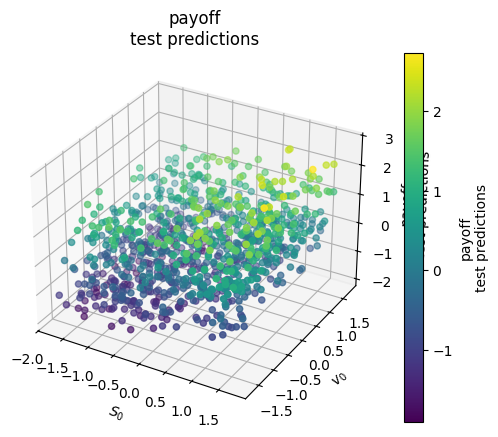

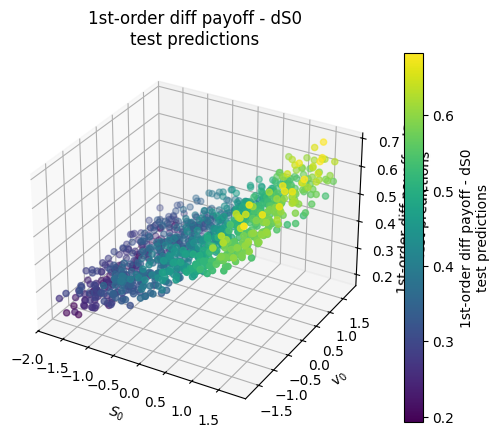

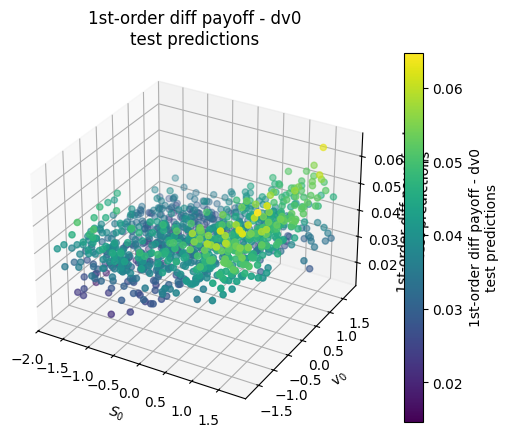

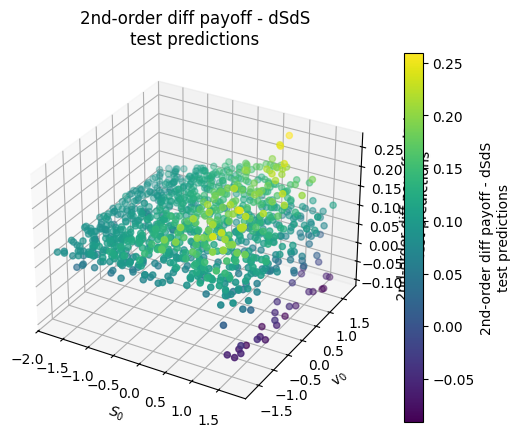

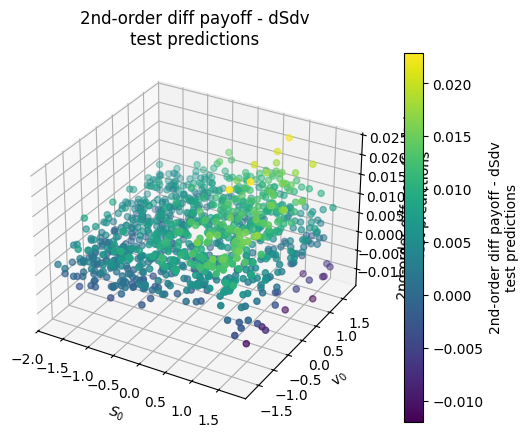

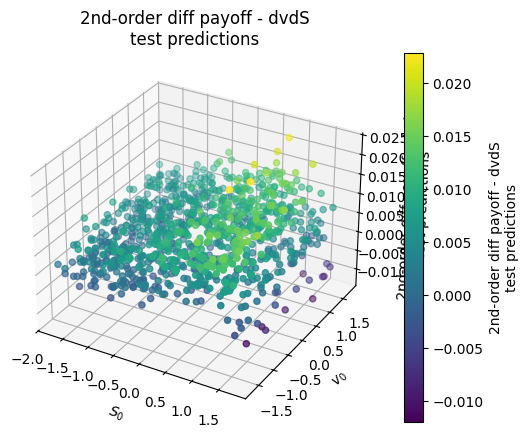

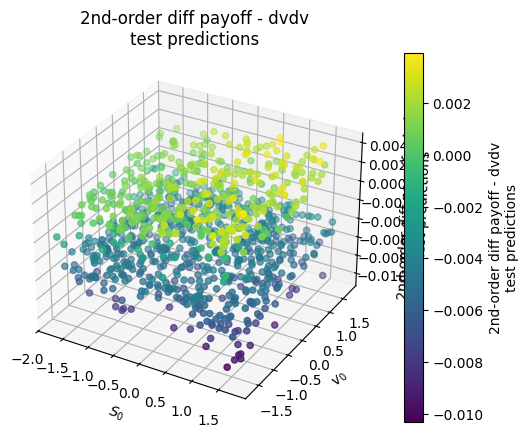

In [77]:
x = test_set[0]
test_size = x.shape[0]

y = test_pred_ys
dydx = test_pred_dys
ddyddx = test_pred_ddys


# for visualization slice out diagonal blocks of Hessian
ddyddx = jnp.stack([ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)



x = x.reshape(test_size, basket_dim, 2)
dydx = dydx.reshape(test_size, basket_dim, 2)
ddyddx = ddyddx.reshape(test_size, basket_dim, 2, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
ddyddx = ddyddx[:, 0, :, :]  # (batch_size, k_probe_directions, 2, 2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




# plot the predictions
xs = x[..., 0]
ys = x[..., 1]



fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest predictions")



fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv0\ntest predictions")



fig_dSdS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], "2nd-order diff payoff - dSdS\ntest predictions")
fig_dSdv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], "2nd-order diff payoff - dSdv\ntest predictions")
fig_dvdS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], "2nd-order diff payoff - dvdS\ntest predictions")
fig_dvdv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], "2nd-order diff payoff - dvdv\ntest predictions")

